"Administrative", "Administrative Duration", "Informational", "Informational Duration", "Product Related" and "Product Related Duration" represent the number of different types of pages visited by the visitor in that session and total time spent in each of these page categories. The values of these features are derived from the URL information of the pages visited by the user and updated in real time when a user takes an action, e.g. moving from one page to another. The "Bounce Rate", "Exit Rate" and "Page Value" features represent the metrics measured by "Google Analytics" for each page in the e-commerce site. The value of "Bounce Rate" feature for a web page refers to the percentage of visitors who enter the site from that page and then leave ("bounce") without triggering any other requests to the analytics server during that session. The value of "Exit Rate" feature for a specific web page is calculated as for all pageviews to the page, the percentage that were the last in the session. The "Page Value" feature represents the average value for a web page that a user visited before completing an e-commerce transaction. The "Special Day" feature indicates the closeness of the site visiting time to a specific special day (e.g. Mother’s Day, Valentine's Day) in which the sessions are more likely to be finalized with transaction. The value of this attribute is determined by considering the dynamics of e-commerce such as the duration between the order date and delivery date. For example, for Valentina’s day, this value takes a nonzero value between February 2 and February 12, zero before and after this date unless it is close to another special day, and its maximum value of 1 on February 8. The dataset also includes operating system, browser, region, traffic type, visitor type as returning or new visitor, a Boolean value indicating whether the date of the visit is weekend, and month of the year.

In [1]:
# Core libraries
import pandas as pd
import numpy as np
import datetime
import math

# Visualization Libraries
import matplotlib.pyplot as plt
import seaborn as sns
# import scikitplot as skplt  # Removed as it's causing the error

# Dataprocessing Libraries
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Libraries for data modeling
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Libraries for model evaluation
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc

# Miscellaneous libraries
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
%pylab inline

Populating the interactive namespace from numpy and matplotlib


## Data Collection

In [2]:
df=pd.read_csv('online_shoppers_intention.csv')
X=df.copy()

## Data Exploration

In [3]:
print(df.head())
df.shape

   Administrative  Administrative_Duration  Informational  \
0               0                      0.0              0   
1               0                      0.0              0   
2               0                      0.0              0   
3               0                      0.0              0   
4               0                      0.0              0   

   Informational_Duration  ProductRelated  ProductRelated_Duration  \
0                     0.0               1                 0.000000   
1                     0.0               2                64.000000   
2                     0.0               1                 0.000000   
3                     0.0               2                 2.666667   
4                     0.0              10               627.500000   

   BounceRates  ExitRates  PageValues  SpecialDay Month  OperatingSystems  \
0         0.20       0.20         0.0         0.0   Feb                 1   
1         0.00       0.10         0.0         0.0   Feb   

(12330, 18)

In [4]:
print(df.dtypes)
print(df.columns)

Administrative               int64
Administrative_Duration    float64
Informational                int64
Informational_Duration     float64
ProductRelated               int64
ProductRelated_Duration    float64
BounceRates                float64
ExitRates                  float64
PageValues                 float64
SpecialDay                 float64
Month                       object
OperatingSystems             int64
Browser                      int64
Region                       int64
TrafficType                  int64
VisitorType                 object
Weekend                       bool
Revenue                       bool
dtype: object
Index(['Administrative', 'Administrative_Duration', 'Informational',
       'Informational_Duration', 'ProductRelated', 'ProductRelated_Duration',
       'BounceRates', 'ExitRates', 'PageValues', 'SpecialDay', 'Month',
       'OperatingSystems', 'Browser', 'Region', 'TrafficType', 'VisitorType',
       'Weekend', 'Revenue'],
      dtype='object')


In [5]:
missing_values=df.isnull().sum()
print(missing_values)

Administrative             0
Administrative_Duration    0
Informational              0
Informational_Duration     0
ProductRelated             0
ProductRelated_Duration    0
BounceRates                0
ExitRates                  0
PageValues                 0
SpecialDay                 0
Month                      0
OperatingSystems           0
Browser                    0
Region                     0
TrafficType                0
VisitorType                0
Weekend                    0
Revenue                    0
dtype: int64


In [6]:
df['Weekend'] = df['Weekend'].astype(bool)
df['Administrative']=df['Administrative'].astype(float)
df['Revenue'] = df['Revenue'].astype(bool)


In [7]:
# numerical, non-numerical and boolean columns
obj_cols = [cols for cols in df.columns if df[cols].dtype == 'object']
bool_cols = [cols for cols in df.columns if df[cols].dtype == 'bool']
num_cols = [cols for cols in df.columns if df[cols].dtype not in ['object','bool']]

print(f'Non-numerical columns:\n{obj_cols}')
print(f'\nBoolean columns:\n{bool_cols}')
print(f'\nNumerical columns:\n{num_cols}')

Non-numerical columns:
['Month', 'VisitorType']

Boolean columns:
['Weekend', 'Revenue']

Numerical columns:
['Administrative', 'Administrative_Duration', 'Informational', 'Informational_Duration', 'ProductRelated', 'ProductRelated_Duration', 'BounceRates', 'ExitRates', 'PageValues', 'SpecialDay', 'OperatingSystems', 'Browser', 'Region', 'TrafficType']


In [8]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Administrative,12330.0,2.315166,3.321784,0.0,0.000000,1.000000,4.000000,27.000000
Administrative_Duration,12330.0,80.818611,176.779107,0.0,0.000000,7.500000,93.256250,3398.750000
Informational,12330.0,0.503569,1.270156,0.0,0.000000,0.000000,0.000000,24.000000
Informational_Duration,12330.0,34.472398,140.749294,0.0,0.000000,0.000000,0.000000,2549.375000
ProductRelated,12330.0,31.731468,44.475503,0.0,7.000000,18.000000,38.000000,705.000000
ProductRelated_Duration,12330.0,1194.746220,1913.669288,0.0,184.137500,598.936905,1464.157214,63973.522230
BounceRates,12330.0,0.022191,0.048488,0.0,0.000000,0.003112,0.016813,0.200000
ExitRates,12330.0,0.043073,0.048597,0.0,0.014286,0.025156,0.050000,0.200000
PageValues,12330.0,5.889258,18.568437,0.0,0.000000,0.000000,0.000000,361.763742
SpecialDay,12330.0,0.061427,0.198917,0.0,0.000000,0.000000,0.000000,1.000000


## Data Visualisation

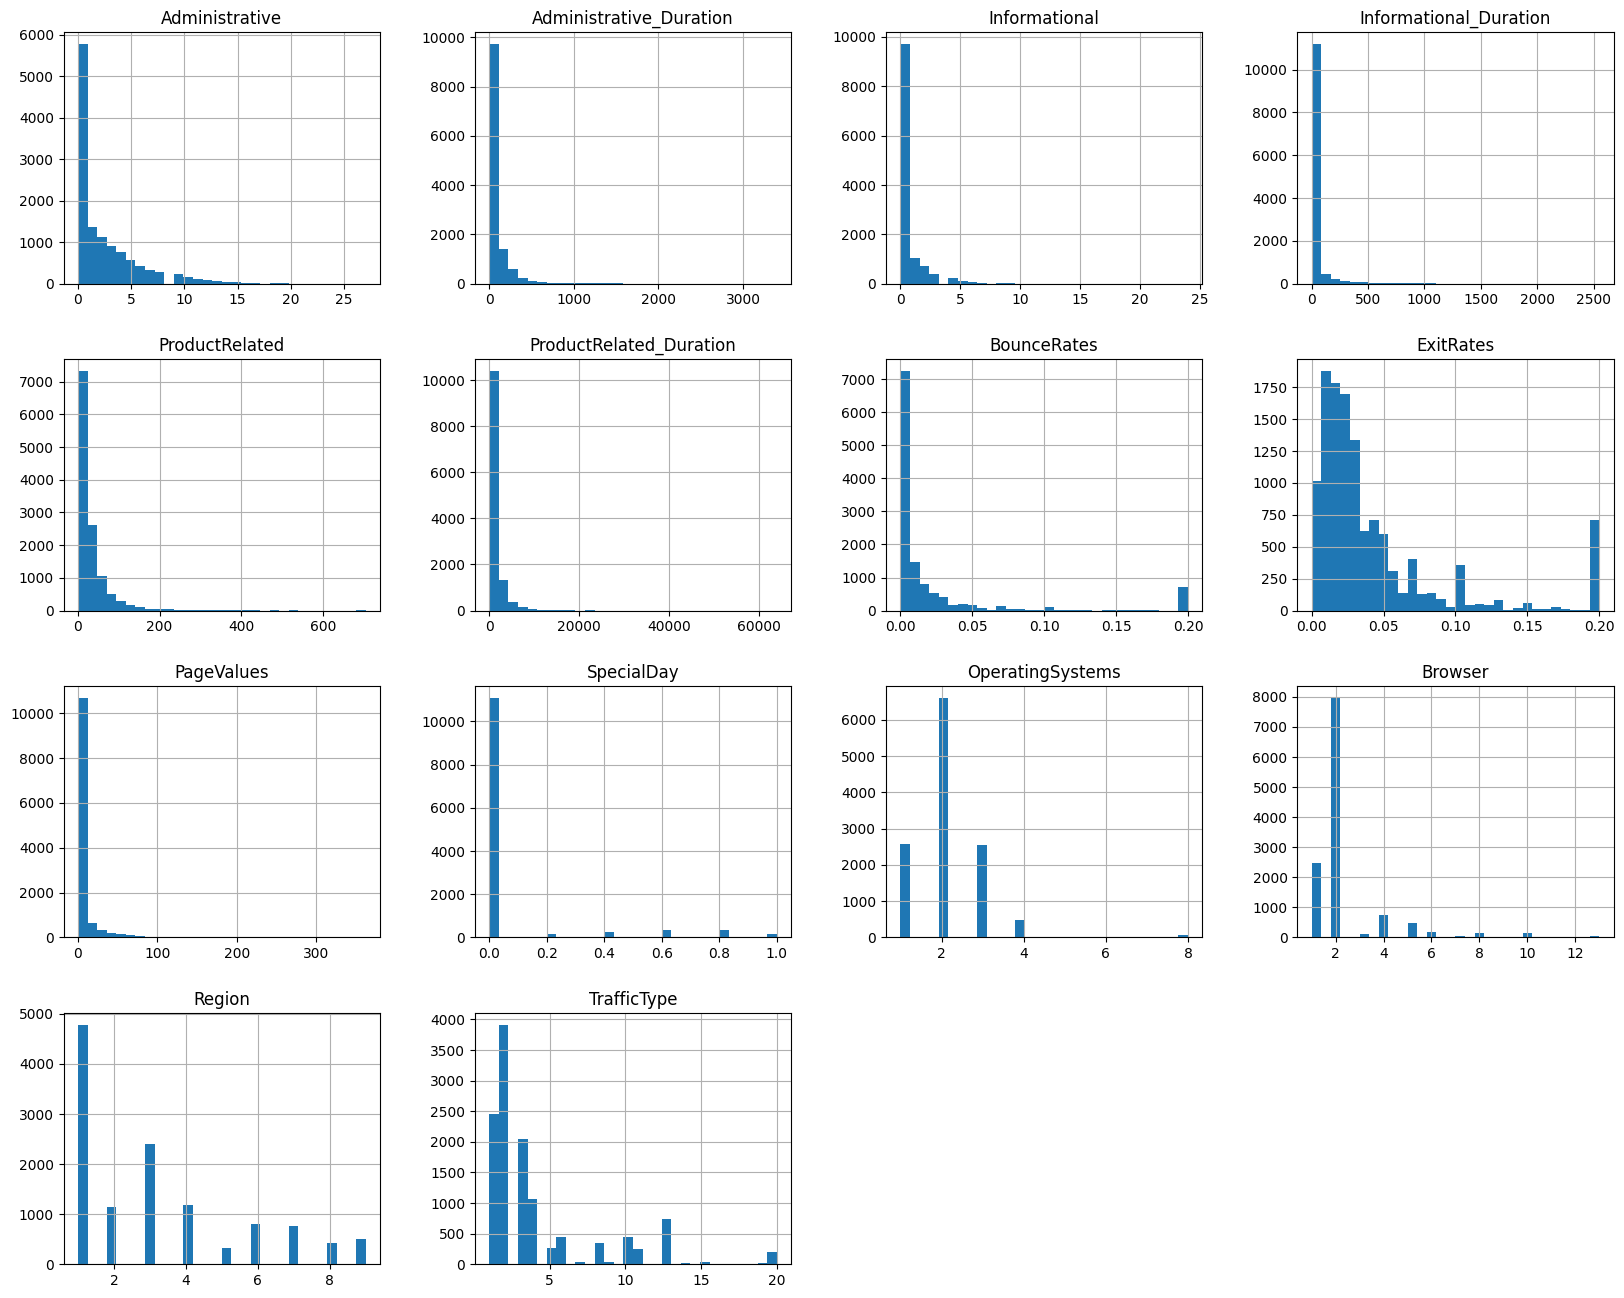

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

# Histogram
df.hist(figsize=(20, 16), bins=30)
plt.show()




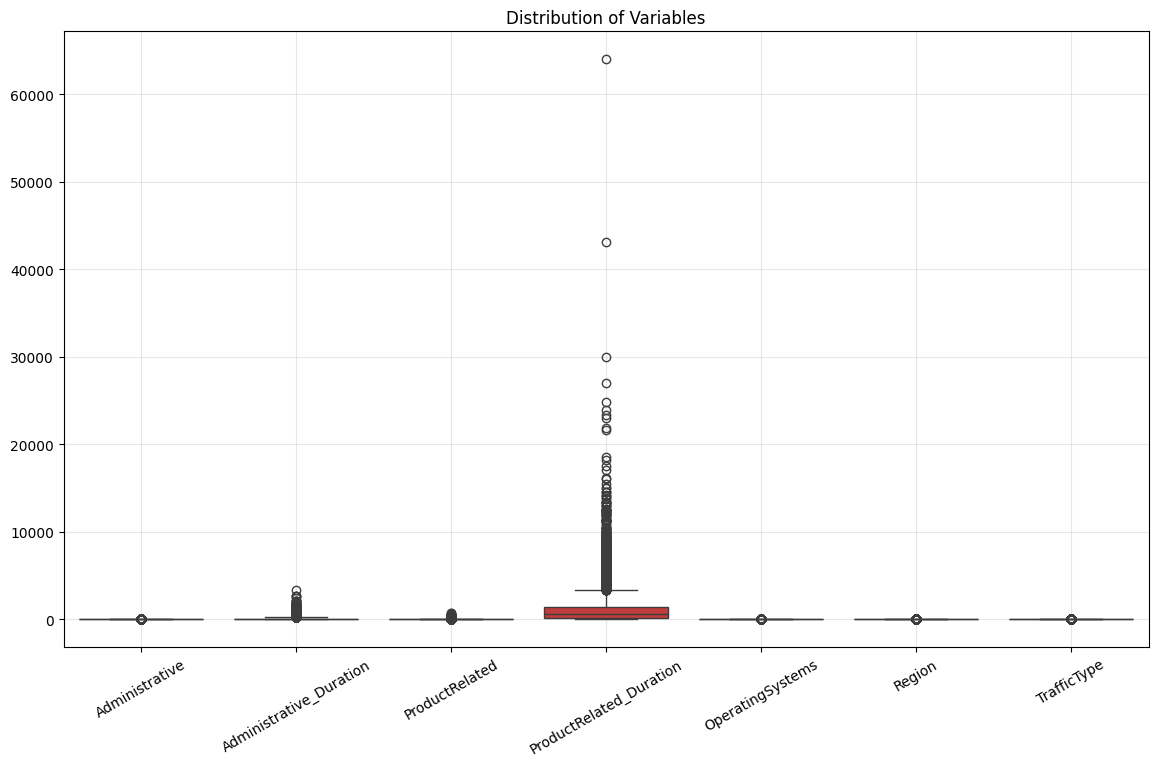

In [10]:

# boxplot of numerical variables
cols = df[['Administrative', 'Administrative_Duration','ProductRelated','ProductRelated_Duration',
            'OperatingSystems','Region', 'TrafficType']]
plt.figure(figsize=(14,8))
fig = sns.boxplot(data=cols)
fig.set_xticklabels(fig.get_xticklabels(),rotation=30)

plt.title('Distribution of Variables')
plt.grid(alpha=0.3)
plt.show()

In [11]:
print('Before Modification')
print(df['Month'].unique())
print()

print('After Modification')
df['Month'] = df['Month'].replace('June', 'Jun', regex=True)
print(df['Month'].unique())

Before Modification
['Feb' 'Mar' 'May' 'Oct' 'June' 'Jul' 'Aug' 'Nov' 'Sep' 'Dec']

After Modification
['Feb' 'Mar' 'May' 'Oct' 'Jun' 'Jul' 'Aug' 'Nov' 'Sep' 'Dec']


In [12]:
df['Month'] = pd.to_datetime(df['Month'], format='%b').dt.month
print(df['Month'])

0         2
1         2
2         2
3         2
4         2
         ..
12325    12
12326    11
12327    11
12328    11
12329    11
Name: Month, Length: 12330, dtype: int32


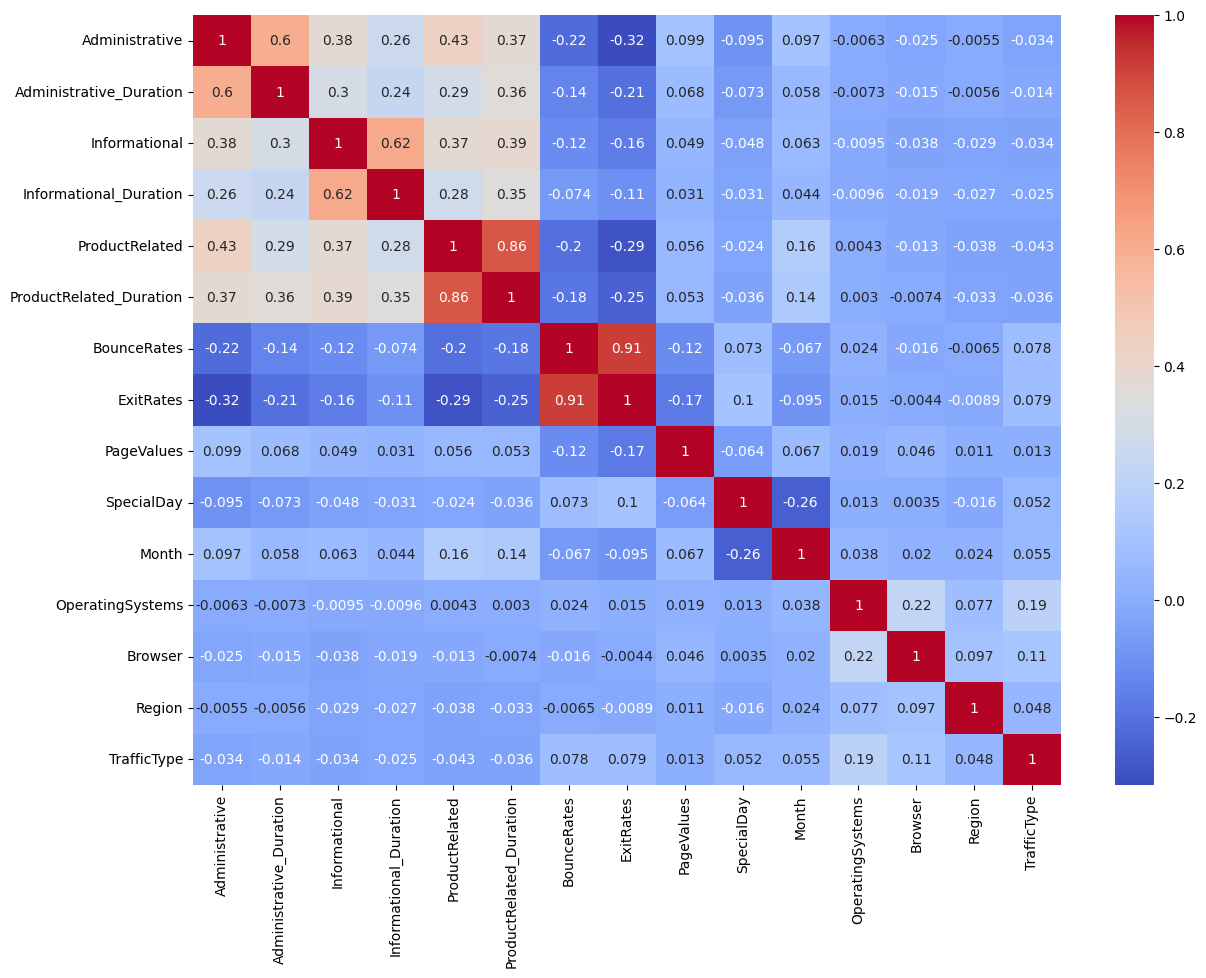

In [13]:
df_numeric = df.select_dtypes(include=['number'])
corr=df_numeric.corr()
fig=plt.figure(figsize=(14,10))
sns.heatmap(corr, annot=True, cmap='coolwarm');

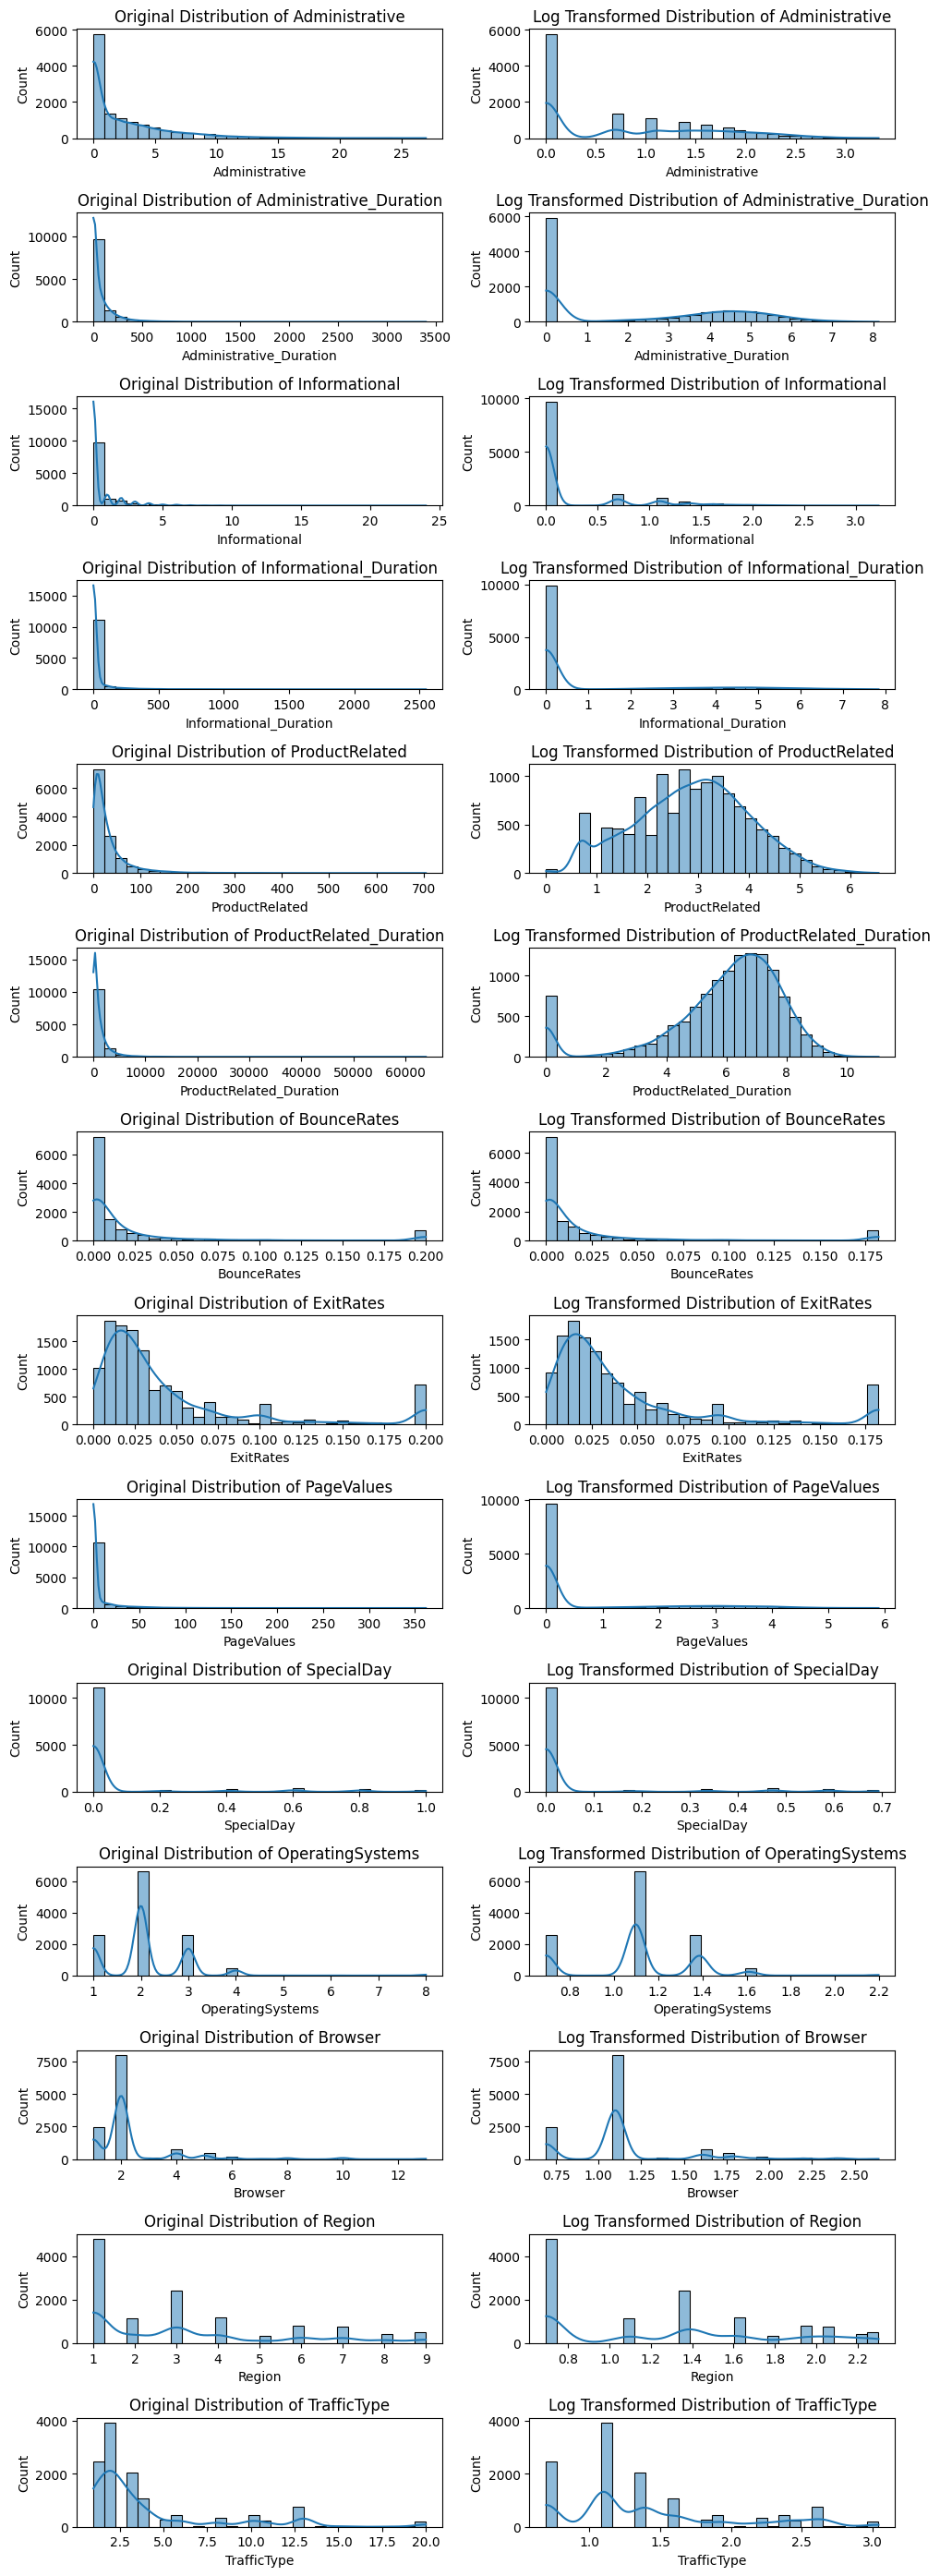

In [14]:
columns_to_normalize = ['Administrative', 'Administrative_Duration', 'Informational',
       'Informational_Duration', 'ProductRelated', 'ProductRelated_Duration',
       'BounceRates', 'ExitRates', 'PageValues', 'SpecialDay',
       'OperatingSystems', 'Browser', 'Region', 'TrafficType'
       ]  # Replace with actual column names
fig, axes = plt.subplots(len(columns_to_normalize), 2, figsize=(10, 2 * len(columns_to_normalize)))

for i, col in enumerate(columns_to_normalize):
    # Plot original distribution
    sns.histplot(df[col], bins=30, kde=True, ax=axes[i, 0])
    axes[i, 0].set_title(f'Original Distribution of {col}')

    # Apply log transformation
    if df[col].min() < 0:  # Shift negative values to positive
        df[col] = df[col] - df[col].min()
    df[col] = np.log1p(df[col])

    # Plot transformed distribution
    sns.histplot(df[col], bins=30, kde=True, ax=axes[i, 1])
    axes[i, 1].set_title(f'Log Transformed Distribution of {col}')

plt.tight_layout()
plt.show()

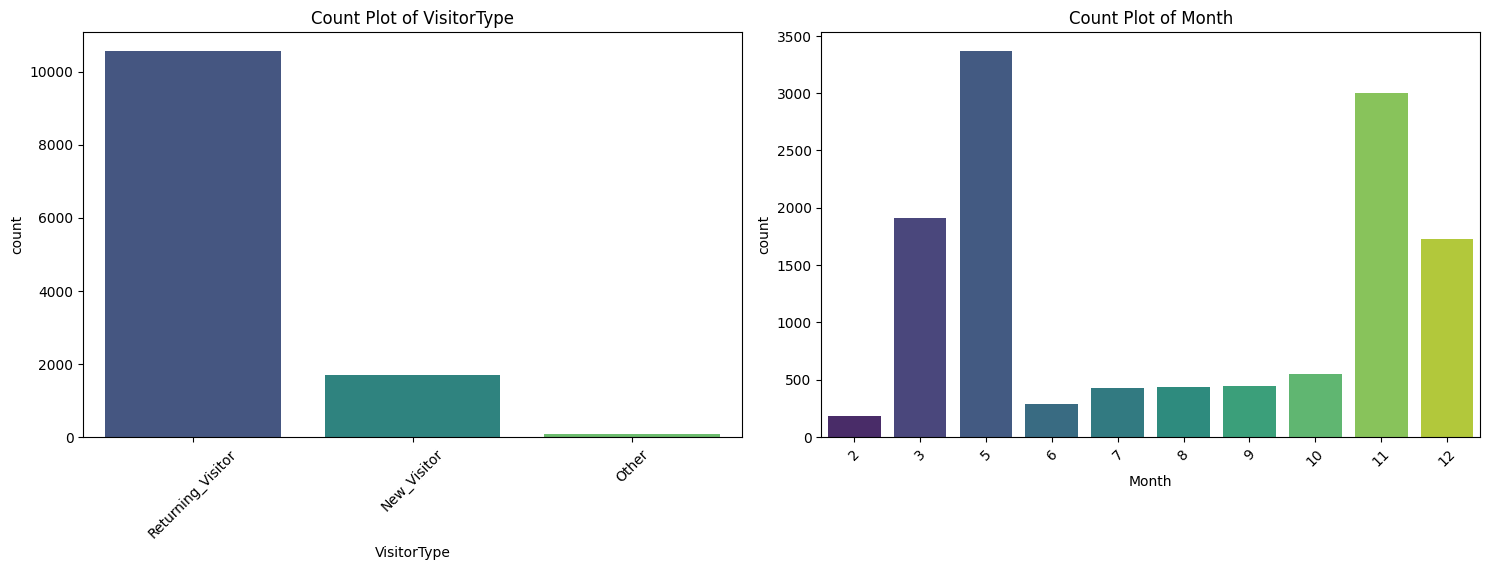

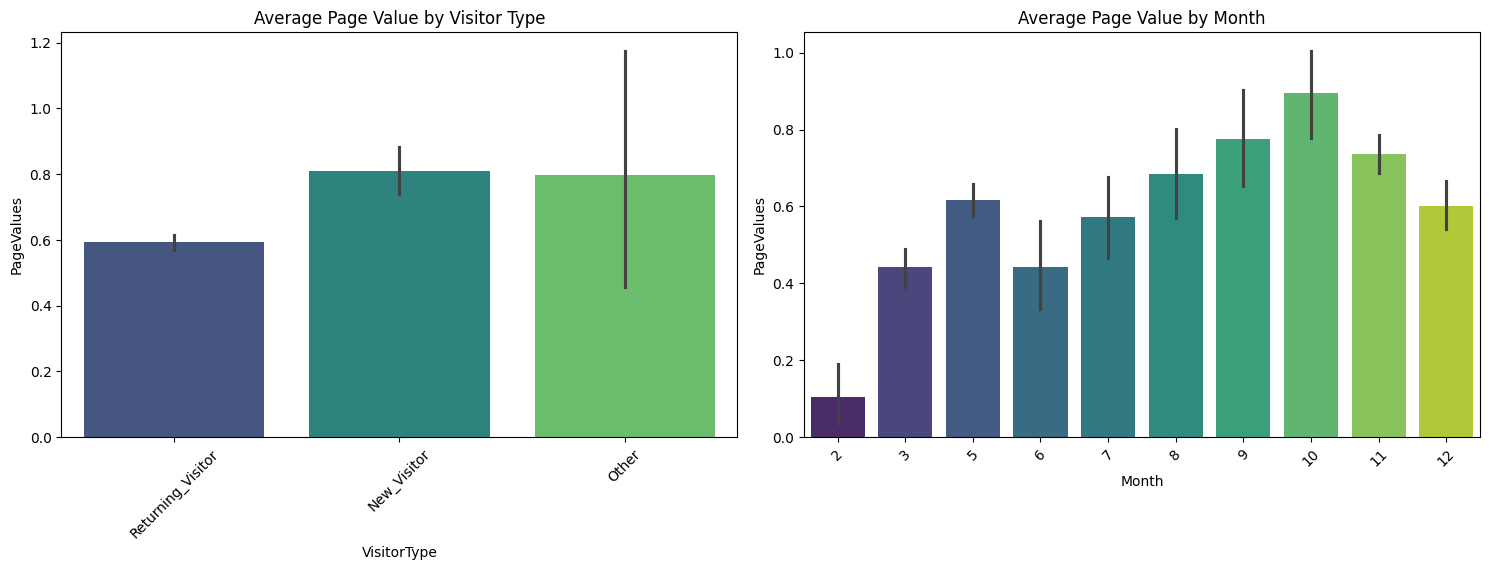

In [15]:
categorical_columns = ['VisitorType', 'Month']

# Bar plots for categorical columns
plt.figure(figsize=(15, 10))

for i, column in enumerate(categorical_columns, 1):
    plt.subplot(2, 2, i)
    sns.countplot(x=column, data=df, palette='viridis')
    plt.title(f'Count Plot of {column}')
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

# Explore relationships between categorical columns and numerical features
# Example: Average "Page Value" by "Visitor Type"
plt.figure(figsize=(15, 10))

# Average Page Value by Visitor Type
plt.subplot(2, 2, 1)
sns.barplot(x='VisitorType', y='PageValues', data=df, palette='viridis', estimator='mean')
plt.title('Average Page Value by Visitor Type')
plt.xticks(rotation=45)

# Average Page Value by Month
plt.subplot(2, 2, 2)
sns.barplot(x='Month', y='PageValues', data=df, palette='viridis', estimator='mean')
plt.title('Average Page Value by Month')
plt.xticks(rotation=45)



plt.tight_layout()
plt.show()

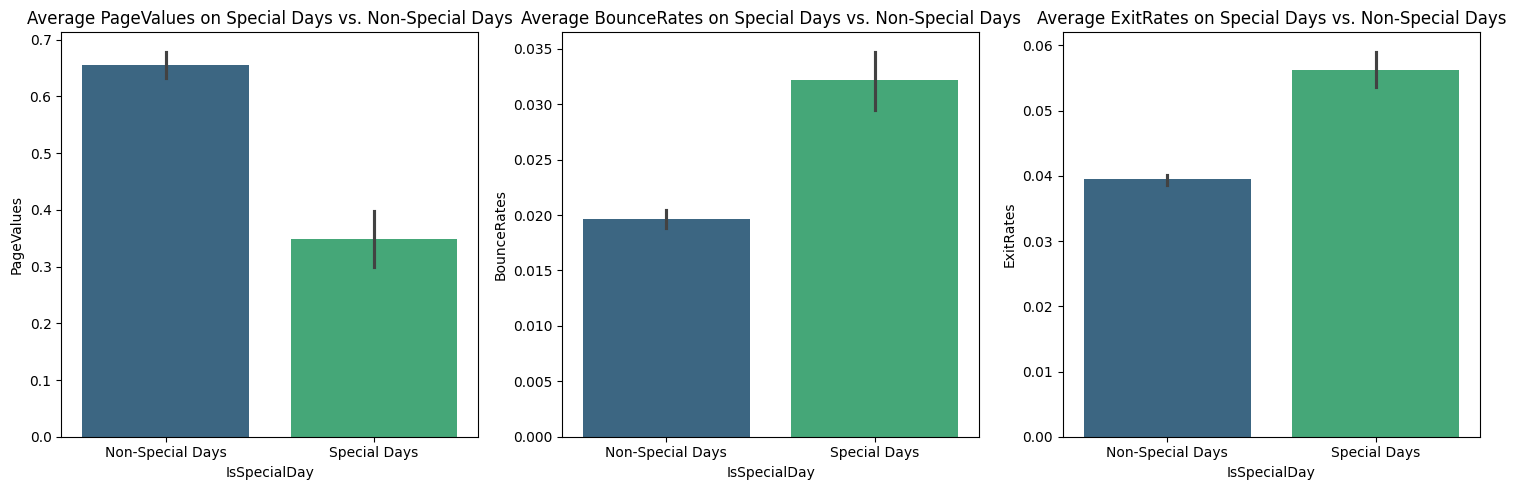

In [16]:
df['IsSpecialDay'] = df['SpecialDay'].apply(lambda x: 1 if x > 0 else 0)

# Metrics to analyze
metrics = ['PageValues', 'BounceRates', 'ExitRates']


# Grouped analysis: Average metrics during special days vs. non-special days
grouped_metrics = df.groupby('IsSpecialDay')[metrics].mean().reset_index()

# Bar plots for average metrics
plt.figure(figsize=(15, 5))

for i, metric in enumerate(metrics, 1):
    plt.subplot(1, 3, i)
    sns.barplot(x='IsSpecialDay', y=metric, data=df, palette='viridis', estimator='mean')
    plt.title(f'Average {metric} on Special Days vs. Non-Special Days')
    plt.xticks(ticks=[0, 1], labels=['Non-Special Days', 'Special Days'])

plt.tight_layout()
plt.show()

In [17]:
df['TotalDuration'] = df['Administrative_Duration'] + df['Informational_Duration'] + df['ProductRelated_Duration']

Average Metrics on Weekends vs. Weekdays:
   Weekend  TotalDuration
0    False       8.975067
1     True       9.570279


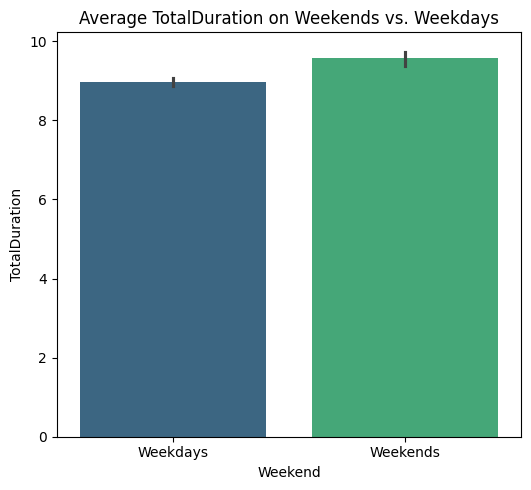

In [18]:
metrics = ['TotalDuration']

grouped_metrics = df.groupby('Weekend')[metrics].mean().reset_index()
print("Average Metrics on Weekends vs. Weekdays:")
print(grouped_metrics)

# Bar plots for average metrics
plt.figure(figsize=(15, 5))

for i, metric in enumerate(metrics, 1):
    plt.subplot(1, 3, i)
    sns.barplot(x='Weekend', y=metric, data=df, palette='viridis', estimator='mean')
    plt.title(f'Average {metric} on Weekends vs. Weekdays')
    plt.xticks(ticks=[0, 1], labels=['Weekdays', 'Weekends'])

plt.tight_layout()
plt.show()


Monthly Revenue Percentage:
   Month    Revenue
0      2   1.630435
1      3  10.068170
2      5  10.850178
3      6  10.069444
4      7  15.277778
5      8  17.551963
6      9  19.196429
7     10  20.947177
8     11  25.350233
9     12  12.507238


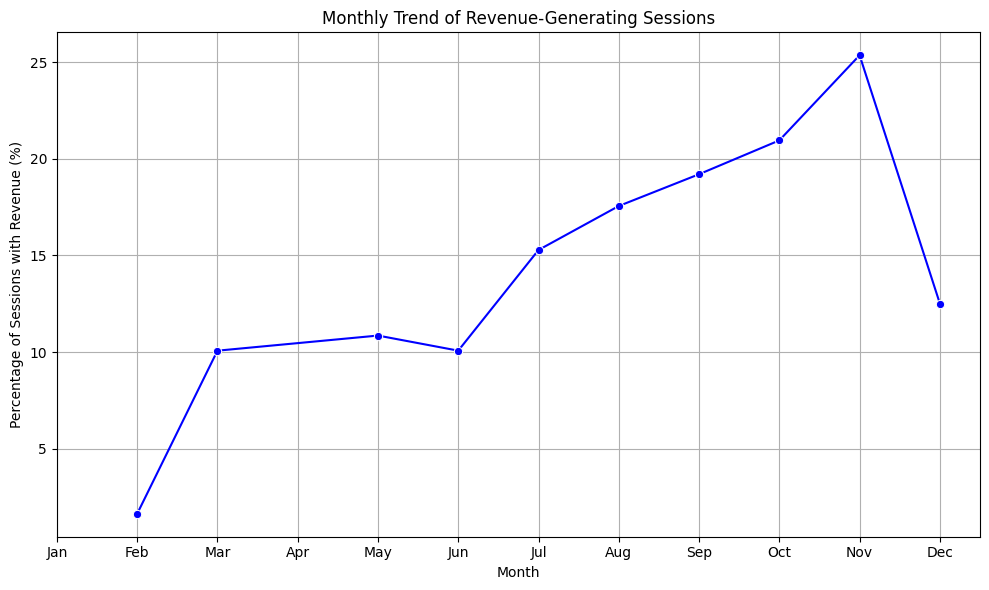

In [19]:
monthly_revenue = df.groupby('Month')['Revenue'].mean() * 100  # Multiply by 100 to get percentage
monthly_revenue = monthly_revenue.reset_index()

# Display the monthly revenue percentage
print("Monthly Revenue Percentage:")
print(monthly_revenue)

# Plotting revenue trend across months
plt.figure(figsize=(10, 6))
sns.lineplot(x='Month', y='Revenue', data=monthly_revenue, marker='o', color='b')
plt.title('Monthly Trend of Revenue-Generating Sessions')
plt.ylabel('Percentage of Sessions with Revenue (%)')
plt.xlabel('Month')
plt.xticks(ticks=range(1, 13), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])  # Map integers to month names
plt.grid(True)
plt.tight_layout()
plt.show()

In [20]:
print(df.dtypes)

Administrative             float64
Administrative_Duration    float64
Informational              float64
Informational_Duration     float64
ProductRelated             float64
ProductRelated_Duration    float64
BounceRates                float64
ExitRates                  float64
PageValues                 float64
SpecialDay                 float64
Month                        int32
OperatingSystems           float64
Browser                    float64
Region                     float64
TrafficType                float64
VisitorType                 object
Weekend                       bool
Revenue                       bool
IsSpecialDay                 int64
TotalDuration              float64
dtype: object


In [21]:
# numerical, non-numerical and boolean columns
obj_cols = [cols for cols in df.columns if df[cols].dtype == 'object']
bool_cols = [cols for cols in df.columns if df[cols].dtype == 'bool']
num_cols = [cols for cols in df.columns if df[cols].dtype not in ['object','bool']]

print(f'Non-numerical columns:\n{obj_cols}')
print(f'\nBoolean columns:\n{bool_cols}')
print(f'\nNumerical columns:\n{num_cols}')

['Administrative', 'Administrative_Duration', 'Informational', 'Informational_Duration', 'ProductRelated', 'ProductRelated_Duration', 'BounceRates', 'ExitRates', 'PageValues', 'SpecialDay', 'OperatingSystems', 'Browser', 'Region', 'TrafficType']

Non-numerical columns:
['VisitorType']

Boolean columns:
['Weekend', 'Revenue']

Numerical columns:
['Administrative', 'Administrative_Duration', 'Informational', 'Informational_Duration', 'ProductRelated', 'ProductRelated_Duration', 'BounceRates', 'ExitRates', 'PageValues', 'SpecialDay', 'Month', 'OperatingSystems', 'Browser', 'Region', 'TrafficType', 'IsSpecialDay', 'TotalDuration']


['Administrative',
 'Administrative_Duration',
 'Informational',
 'Informational_Duration',
 'ProductRelated',
 'ProductRelated_Duration',
 'BounceRates',
 'ExitRates',
 'PageValues',
 'SpecialDay',
 'OperatingSystems',
 'Browser',
 'Region',
 'TrafficType']

## Data Processing

In [22]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Select only numerical features (excluding categorical ones)
numeric_features = ['Administrative', 'Administrative_Duration', 'Informational',
                    'Informational_Duration', 'ProductRelated', 'ProductRelated_Duration',
                    'BounceRates', 'ExitRates', 'PageValues', 'SpecialDay', 'TotalDuration']

# Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df[numeric_features])

# Apply PCA without specifying n_components to get all components
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

# Get explained variance (eigenvalues)
explained_variance = pca.explained_variance_

# Compute proportion variance (percentage contribution of each component)
proportion_variance = pca.explained_variance_ratio_

# Compute cumulative proportion variance
cumulative_variance = np.cumsum(proportion_variance)

# Print output in required format
print("Explained variance :")
print(np.round(explained_variance, 8))  # Rounded for readability

print("\nProportion Variance :")
print(np.round(proportion_variance, 8))

print("\nCumulative proportion :")
print(np.round(cumulative_variance, 8))


Explained variance :
[5.31367876 1.76306234 1.17617704 0.96846703 0.86572644 0.5626114
 0.12412789 0.09039712 0.07692857 0.0597156  0.        ]

Proportion Variance :
[0.48302253 0.1602654  0.10691651 0.08803532 0.07869602 0.05114234
 0.01128344 0.00821725 0.00699294 0.00542825 0.        ]

Cumulative proportion :
[0.48302253 0.64328792 0.75020444 0.83823975 0.91693577 0.96807812
 0.97936156 0.98757881 0.99457175 1.         1.        ]


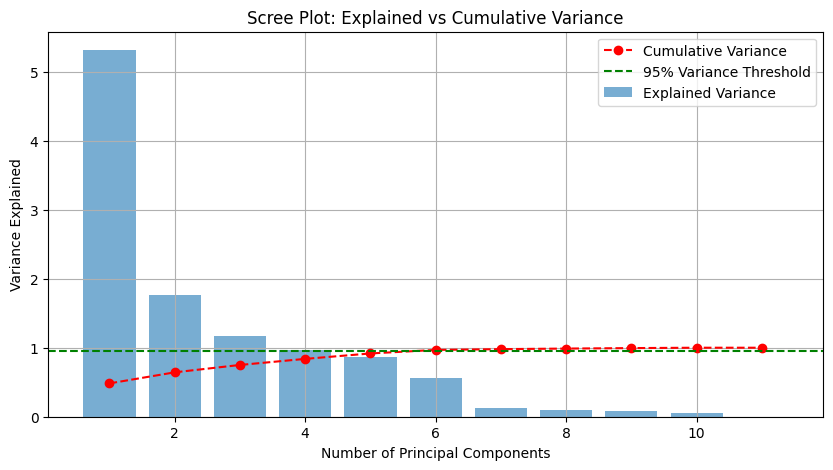

In [23]:

# Plot Scree Plot
plt.figure(figsize=(10, 5))
plt.bar(range(1, len(explained_variance) + 1), explained_variance, alpha=0.6, label="Explained Variance")
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', linestyle='--', color='r', label="Cumulative Variance")

plt.xlabel("Number of Principal Components")
plt.ylabel("Variance Explained")
plt.title("Scree Plot: Explained vs Cumulative Variance")
plt.axhline(y=0.95, color='g', linestyle='--', label="95% Variance Threshold")
plt.legend()
plt.grid()

# Show plot
plt.show()

The bar chart shows the variance explained by each individual principal component.
The red line (cumulative variance) shows how variance accumulates when adding more components.
If the cumulative variance reaches near 100% only when all components are included, this means that dropping components will significantly reduce the amount of variance retained in the dataset.
The green dashed line at 95% variance helps determine how many components are needed to retain most of the variance.


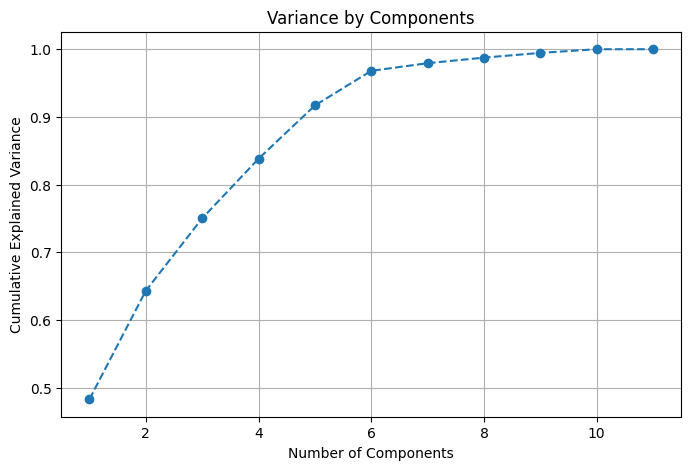

In [24]:
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', linestyle='dashed')

# Labels and grid
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Variance by Components')
plt.grid(True)

# Show the plot
plt.show()

The above figure indicates that retaining all features is essential for maximizing variance in the dataset. It underscores the importance of preserving the entirety of the original feature set to capture the maximum amount of variability present in the data. By maintaining all features, we ensure that no potentially valuable information is lost during the dimensionality reduction process.

##Getting Data Ready For Training

In [25]:
# load data
data=pd.read_csv('online_shoppers_intention.csv')

In [26]:
data.head()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
0,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,1,1,1,1,Returning_Visitor,False,False
1,0,0.0,0,0.0,2,64.000000,0.00,0.10,0.0,0.0,Feb,2,2,1,2,Returning_Visitor,False,False
2,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,4,1,9,3,Returning_Visitor,False,False
3,0,0.0,0,0.0,2,2.666667,0.05,0.14,0.0,0.0,Feb,3,2,2,4,Returning_Visitor,False,False
4,0,0.0,0,0.0,10,627.500000,0.02,0.05,0.0,0.0,Feb,3,3,1,4,Returning_Visitor,True,False


In [27]:
data.Weekend = data.Weekend.map(lambda x: 0 if x is False else 1)
data.Revenue = data.Revenue.map(lambda x: 0 if x is False else 1)

In [28]:
data.Month.unique()

array(['Feb', 'Mar', 'May', 'Oct', 'June', 'Jul', 'Aug', 'Nov', 'Sep',
       'Dec'], dtype=object)

In [29]:
months = {
    'Feb': 2,
    'Mar': 3,
    'May': 5,
    'June': 6,
    'Jul': 7,
    'Aug': 8,
    'Sep': 9,
    'Oct': 10,
    'Nov': 11,
    'Dec': 12
}

data['Month'] = data['Month'].map(months)

In [30]:
data.VisitorType.value_counts()

,count
VisitorType,
Returning_Visitor,10551
New_Visitor,1694
Other,85


In [31]:
# create columns for categorical values of column Visitortype
x1 = pd.get_dummies(data.VisitorType)
data = pd.concat([data,x1],axis=1)

In [32]:
# drop redundant columns
data.drop(['VisitorType','Other'],axis=1,inplace=True)

In [33]:
data = data[['Administrative', 'Administrative_Duration', 'Informational',
       'Informational_Duration', 'ProductRelated', 'ProductRelated_Duration',
       'BounceRates', 'ExitRates', 'PageValues', 'SpecialDay', 'Month',
       'OperatingSystems', 'Browser', 'Region', 'TrafficType', 'Weekend',
       'New_Visitor', 'Returning_Visitor','Revenue']]

In [34]:
# Data Standardization
Scaler = StandardScaler()
scaled_x = Scaler.fit_transform(data.drop(columns=['Revenue']))

In [35]:
data1 = pd.DataFrame(scaled_x,columns=data.columns[:-1])
data1.head()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,Weekend,New_Visitor,Returning_Visitor
0,-0.696993,-0.457191,-0.396478,-0.244931,-0.691003,-0.624348,3.667189,3.229316,-0.317178,-0.308821,-1.665924,-1.233426,-0.790293,-0.894178,-0.762629,-0.550552,-0.399087,0.410621
1,-0.696993,-0.457191,-0.396478,-0.244931,-0.668518,-0.590903,-0.457683,1.171473,-0.317178,-0.308821,-1.665924,-0.136078,-0.207952,-0.894178,-0.514182,-0.550552,-0.399087,0.410621
2,-0.696993,-0.457191,-0.396478,-0.244931,-0.691003,-0.624348,3.667189,3.229316,-0.317178,-0.308821,-1.665924,2.058618,-0.790293,2.437081,-0.265735,-0.550552,-0.399087,0.410621
3,-0.696993,-0.457191,-0.396478,-0.244931,-0.668518,-0.622954,0.573535,1.994610,-0.317178,-0.308821,-1.665924,0.961270,-0.207952,-0.477771,-0.017289,-0.550552,-0.399087,0.410621
4,-0.696993,-0.457191,-0.396478,-0.244931,-0.488636,-0.296430,-0.045196,0.142551,-0.317178,-0.308821,-1.665924,0.961270,0.374389,-0.894178,-0.017289,1.816360,-0.399087,0.410621


In [36]:
# assigning predictor variables and target into x and y
X = data1
y = data[['Revenue']]

##Here we have imbalanced dataset, so performed oversampling

In [37]:
# Initialize SMOTE
smote = SMOTE(random_state=42)

In [38]:
# Perform oversampling
X_resampled, y_resampled = smote.fit_resample(X, y)

In [39]:
# split data into train test validation set
X_train,X_temp,y_train,y_temp = train_test_split(X_resampled,y_resampled,test_size=0.22,random_state=42)
X_val,X_test,y_val,y_test = train_test_split(X_temp,y_temp,test_size=0.5,random_state=42)

In [40]:
print("X_train shape:", X_train.shape)
print("X_val shape:", X_val.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_val shape:", y_val.shape)
print("y_test shape:", y_test.shape)

X_train shape: (16258, 18)
X_val shape: (2293, 18)
X_test shape: (2293, 18)
y_train shape: (16258, 1)
y_val shape: (2293, 1)
y_test shape: (2293, 1)


##Model Performace Evaluation and Interpretation

We will choose the best model among 5 Models based on the performance metrics:

Logistic Regression

K-Nearest Neighbors

Decision Tree

Support vector machine

Neural network (MLP)

##Logistic Regression

In [41]:
model = LogisticRegression()
model.fit(X_train,y_train)

LogisticRegression()

In [42]:
y_pred = model.predict(X_val)
Lr_accuracy = accuracy_score(y_val,y_pred)
print(f'The Accuracy of the model using Logistic Regression is: {round(Lr_accuracy,3)}')

The Accuracy of the model using Logistic Regression is: 0.826


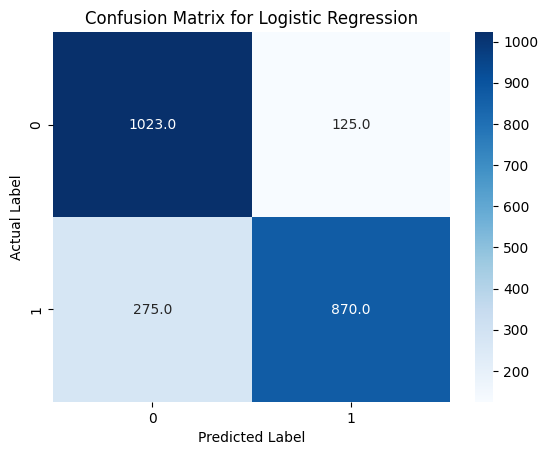

In [43]:
cm = confusion_matrix(y_val, y_pred)

sns.heatmap(cm, annot=True, fmt='.1f', cmap='Blues')
plt.title('Confusion Matrix for Logistic Regression')
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label');

In [44]:
classification = classification_report(y_val,y_pred)
print(f'The Classification report of the model using Logistic Regression is:\n {classification}')

The Classification report of the model using Logistic Regression is:
               precision    recall  f1-score   support

           0       0.79      0.89      0.84      1148
           1       0.87      0.76      0.81      1145

    accuracy                           0.83      2293
   macro avg       0.83      0.83      0.82      2293
weighted avg       0.83      0.83      0.82      2293



In [45]:
!pip install scikit-plot

!pip install --upgrade scikit-plot


In [46]:
!pip show scikit-plot


Name: scikit-plot
Version: 0.3.7
Summary: An intuitive library to add plotting functionality to scikit-learn objects.
Home-page: https://github.com/reiinakano/scikit-plot
Author: Reiichiro Nakano
Author-email: reiichiro.s.nakano@gmail.com
License: MIT License
Location: /usr/local/lib/python3.11/dist-packages
Requires: joblib, matplotlib, scikit-learn, scipy
Required-by: 


In [47]:
!pip install scipy==1.9.3


In [48]:
import scikitplot as skplt


(0.0, 1.1)

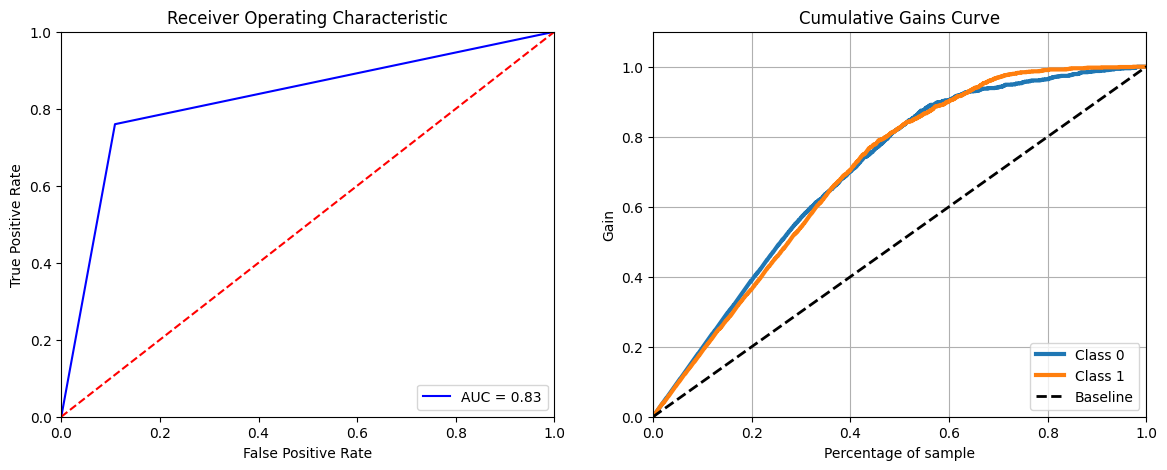

In [49]:
# Calculating ROC
fpr, tpr, threshold = roc_curve(y_val, y_pred)
roc_auc = auc(fpr, tpr)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5), sharex=False)
ax1.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
ax1.plot([0, 1], [0, 1],'r--')
ax1.set_title('Receiver Operating Characteristic')
ax1.set_ylabel('True Positive Rate')
ax1.set_xlabel('False Positive Rate')
ax1.legend(loc = 'lower right')
ax1.set_xlim([0, 1])
ax1.set_ylim([0, 1])

skplt.metrics.plot_cumulative_gain(y_val,model.predict_proba(X_val), ax=ax2)
ax2.set_ylim([0, 1.1])

##K-Nearest Neighbours (KNN)

Using KNN with Manhattan Distance

Testing for 1 neighbour..
The Accuracy for 1 neighbours is: 0.93

Testing for 2 neighbour..
The Accuracy for 2 neighbours is: 0.93

Testing for 3 neighbour..
The Accuracy for 3 neighbours is: 0.91

Testing for 4 neighbour..
The Accuracy for 4 neighbours is: 0.91

Testing for 5 neighbour..
The Accuracy for 5 neighbours is: 0.9



Text(0, 0.5, 'Accuracy')

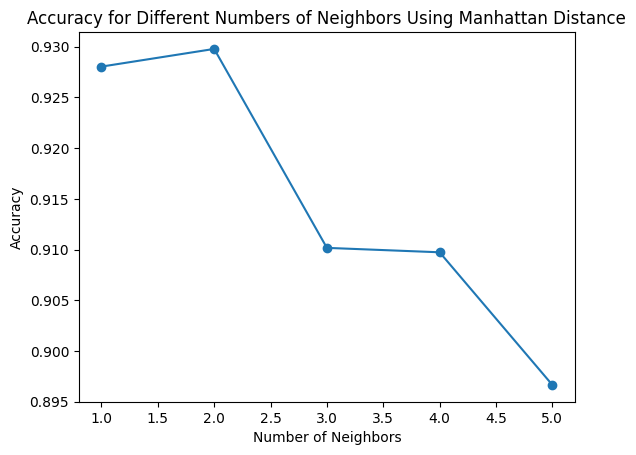

In [50]:
knn_acc = []

for k in range(1,6):
    print(f'Testing for {k} neighbour..')
    model = KNeighborsClassifier(n_neighbors=k, metric='manhattan')
    model.fit(X_train,y_train)
    y_pred = model.predict(X_val)

    # Accuracy
    accuracy = accuracy_score(y_val,y_pred)
    knn_acc.append(accuracy)
    print(f'The Accuracy for {k} neighbours is: {round(accuracy,2)}\n')

plt.plot(range(1, len(knn_acc) + 1), knn_acc, marker='o')
plt.title('Accuracy for Different Numbers of Neighbors Using Manhattan Distance')
plt.xlabel('Number of Neighbors')
plt.ylabel('Accuracy')

Using KNN with Euclidean Distance

Testing for 1 neighbour..
The Accuracy for 1 neighbours is: 0.91

Testing for 2 neighbour..
The Accuracy for 2 neighbours is: 0.92

Testing for 3 neighbour..
The Accuracy for 3 neighbours is: 0.89

Testing for 4 neighbour..
The Accuracy for 4 neighbours is: 0.89

Testing for 5 neighbour..
The Accuracy for 5 neighbours is: 0.87



Text(0, 0.5, 'Accuracy')

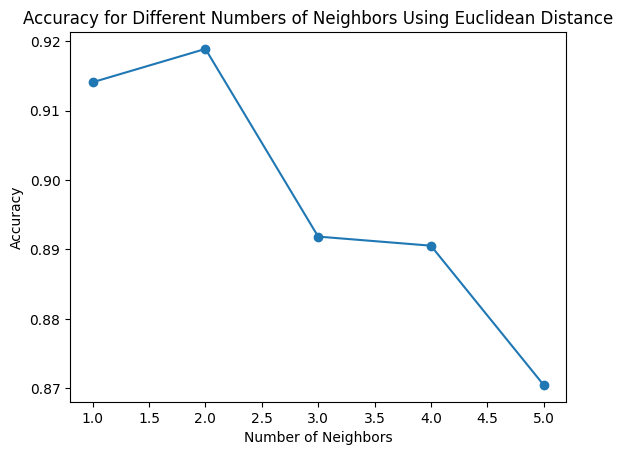

In [51]:
knn_acc = []

for k in range(1,6):
    print(f'Testing for {k} neighbour..')
    model = KNeighborsClassifier(n_neighbors=k, metric='euclidean')
    model.fit(X_train,y_train)
    y_pred = model.predict(X_val)

    # Accuracy
    accuracy = accuracy_score(y_val,y_pred)
    knn_acc.append(accuracy)
    print(f'The Accuracy for {k} neighbours is: {round(accuracy,2)}\n')

plt.plot(range(1, len(knn_acc) + 1), knn_acc, marker='o')
plt.title('Accuracy for Different Numbers of Neighbors Using Euclidean Distance')
plt.xlabel('Number of Neighbors')
plt.ylabel('Accuracy')

Based on the preceding analysis, it becomes evident that the KNN model yields optimal outcomes when configured with a neighbor count of 2 and employing Manhattan distance for distance calculation.

In [52]:
model = KNeighborsClassifier(n_neighbors=2, metric='manhattan')
model.fit(X_train,y_train)

KNeighborsClassifier(metric='manhattan', n_neighbors=2)

In [53]:
y_pred = model.predict(X_val)
Knn_accuracy = accuracy_score(y_val,y_pred)
print(f'The Accuracy of the model using K-Nearest Neighbor is: {round(Knn_accuracy,3)}')

The Accuracy of the model using K-Nearest Neighbor is: 0.93


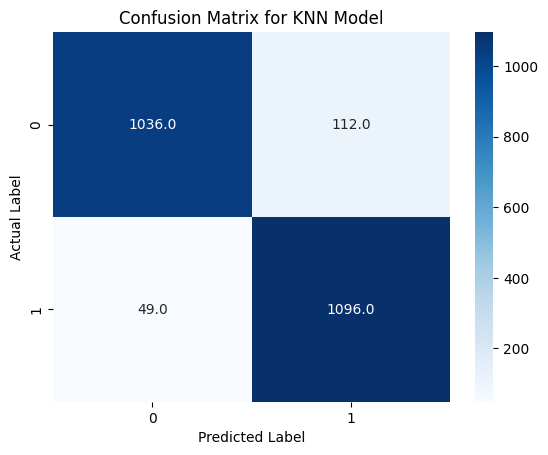

In [54]:
cm = confusion_matrix(y_val, y_pred)

sns.heatmap(cm, annot=True, fmt='.1f', cmap='Blues')
plt.title('Confusion Matrix for KNN Model')
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label');

In [55]:
classification = classification_report(y_val,y_pred)
print(f'The Classification report of the model using K-Nearest Neighbor is:\n {classification}')

The Classification report of the model using K-Nearest Neighbor is:
               precision    recall  f1-score   support

           0       0.95      0.90      0.93      1148
           1       0.91      0.96      0.93      1145

    accuracy                           0.93      2293
   macro avg       0.93      0.93      0.93      2293
weighted avg       0.93      0.93      0.93      2293



(0.0, 1.1)

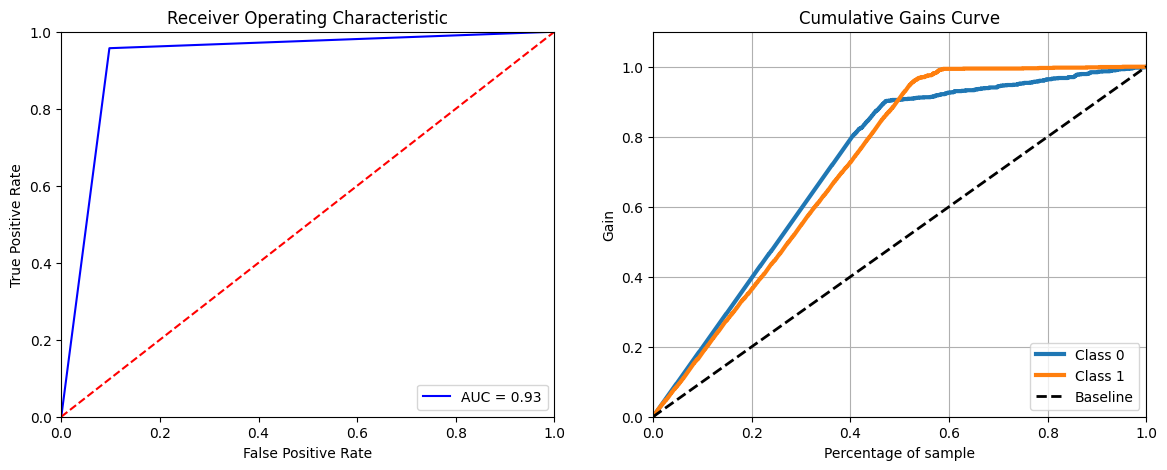

In [56]:
# Calculating ROC
fpr, tpr, threshold = roc_curve(y_val, y_pred)
roc_auc = auc(fpr, tpr)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5), sharex=False)
ax1.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
ax1.plot([0, 1], [0, 1],'r--')
ax1.set_title('Receiver Operating Characteristic')
ax1.set_ylabel('True Positive Rate')
ax1.set_xlabel('False Positive Rate')
ax1.legend(loc = 'lower right')
ax1.set_xlim([0, 1])
ax1.set_ylim([0, 1])

skplt.metrics.plot_cumulative_gain(y_val,model.predict_proba(X_val), ax=ax2)
ax2.set_ylim([0, 1.1])

##Decision Tree


In [57]:
model = DecisionTreeClassifier()
model.fit(X_train,y_train)

DecisionTreeClassifier()

In [58]:
y_pred = model.predict(X_val)
Dt_accuracy = accuracy_score(y_val,y_pred)
print(f'The Accuracy of the model using Decision Tree is: {round(Dt_accuracy,3)}')

The Accuracy of the model using Decision Tree is: 0.906


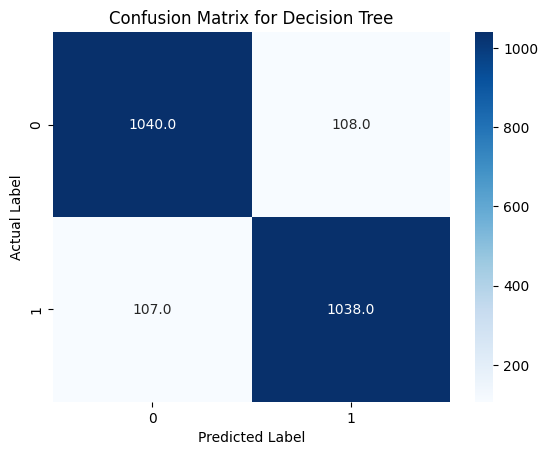

In [59]:
cm = confusion_matrix(y_val, y_pred)

sns.heatmap(cm, annot=True, fmt='.1f', cmap='Blues')
plt.title('Confusion Matrix for Decision Tree')
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label');

In [60]:
classification = classification_report(y_val,y_pred)
print(f'The Classification report of the model using Decision Tree is:\n {classification}')

The Classification report of the model using Decision Tree is:
               precision    recall  f1-score   support

           0       0.91      0.91      0.91      1148
           1       0.91      0.91      0.91      1145

    accuracy                           0.91      2293
   macro avg       0.91      0.91      0.91      2293
weighted avg       0.91      0.91      0.91      2293



(0.0, 1.1)

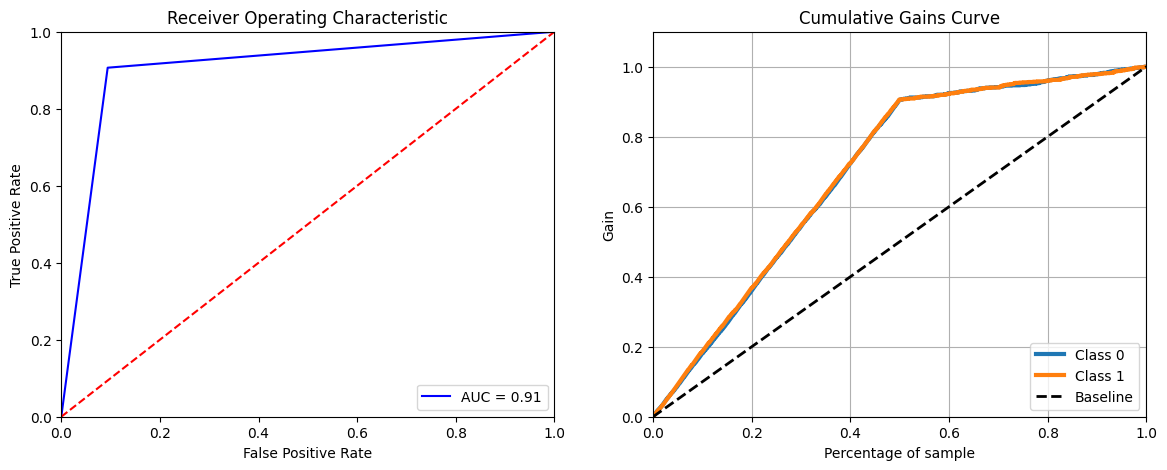

In [61]:
# Calculating ROC
fpr, tpr, threshold = roc_curve(y_val, y_pred)
roc_auc = auc(fpr, tpr)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5), sharex=False)
ax1.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
ax1.plot([0, 1], [0, 1],'r--')
ax1.set_title('Receiver Operating Characteristic')
ax1.set_ylabel('True Positive Rate')
ax1.set_xlabel('False Positive Rate')
ax1.legend(loc = 'lower right')
ax1.set_xlim([0, 1])
ax1.set_ylim([0, 1])

skplt.metrics.plot_cumulative_gain(y_val,model.predict_proba(X_val), ax=ax2)
ax2.set_ylim([0, 1.1])

##Support Vector Machine

In [62]:
model = SVC(probability=True)
model.fit(X_train,y_train)

SVC(probability=True)

In [63]:
y_pred = model.predict(X_val)
SVC_accuracy = accuracy_score(y_val,y_pred)
print(f'The Accuracy of the model using Support Vector Machine is: {round(SVC_accuracy,3)}')

The Accuracy of the model using Support Vector Machine is: 0.863


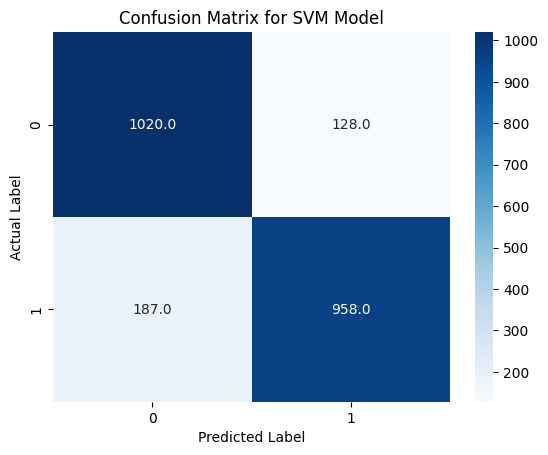

In [64]:
cm = confusion_matrix(y_val, y_pred)

sns.heatmap(cm, annot=True, fmt='.1f', cmap='Blues')
plt.title('Confusion Matrix for SVM Model')
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label');

In [65]:
classification = classification_report(y_val,y_pred)
print(f'The Classification report of the model using Support Vector Machine is:\n {classification}')


The Classification report of the model using Support Vector Machine is:
               precision    recall  f1-score   support

           0       0.85      0.89      0.87      1148
           1       0.88      0.84      0.86      1145

    accuracy                           0.86      2293
   macro avg       0.86      0.86      0.86      2293
weighted avg       0.86      0.86      0.86      2293



(0.0, 1.1)

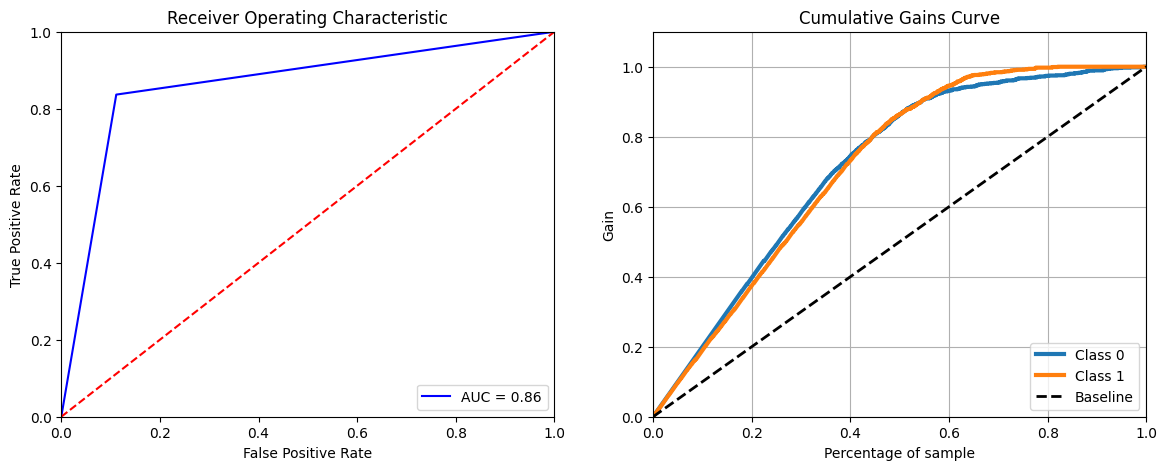

In [66]:
# Calculating ROC
fpr, tpr, threshold = roc_curve(y_val, y_pred)
roc_auc = auc(fpr, tpr)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5), sharex=False)
ax1.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
ax1.plot([0, 1], [0, 1],'r--')
ax1.set_title('Receiver Operating Characteristic')
ax1.set_ylabel('True Positive Rate')
ax1.set_xlabel('False Positive Rate')
ax1.legend(loc = 'lower right')
ax1.set_xlim([0, 1])
ax1.set_ylim([0, 1])

skplt.metrics.plot_cumulative_gain(y_val,model.predict_proba(X_val), ax=ax2)
ax2.set_ylim([0, 1.1])

##Neural Networks


In [67]:
model = keras.Sequential([
    layers.Dense(64,activation='relu'),
    layers.Dense(64,activation='relu'),
    layers.Dense(1,activation='sigmoid')
])

In [68]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [69]:
model.fit(X_train,y_train,epochs=12,batch_size=32,verbose=1);

Epoch 1/12
509/509 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.7365 - loss: 0.5072
Epoch 2/12
509/509 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8555 - loss: 0.3402
Epoch 3/12
509/509 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8692 - loss: 0.3169
Epoch 4/12
509/509 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8754 - loss: 0.2986
Epoch 5/12
509/509 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8800 - loss: 0.2869
Epoch 6/12
509/509 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8849 - loss: 0.2776
Epoch 7/12
509/509 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8830 - loss: 0.2766
Epoch 8/12
509/509 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8890 - loss: 0.2642
Epoch 9/12
509/509 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8889 - loss: 0.2651
Epoch 10/12
509/509 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8954 - loss: 0.2539
Epoch 11/12
509/509 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9037 - loss: 0.2441
Epoch 12/12
509/509 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

In [70]:
y_pred = model.predict(X_val)
y_pred = np.round(y_pred).flatten()

72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


In [71]:
NN_accuracy = accuracy_score(y_val,y_pred)
print(f'The Accuracy of the model using MultiLayer Perceptron is: {round(NN_accuracy,3)}')

The Accuracy of the model using MultiLayer Perceptron is: 0.883


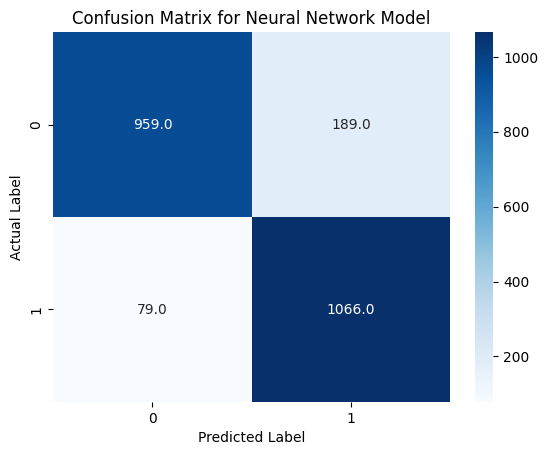

In [72]:
cm = confusion_matrix(y_val, y_pred)

sns.heatmap(cm, annot=True, fmt='.1f', cmap='Blues')
plt.title('Confusion Matrix for Neural Network Model')
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label');

In [73]:
classification = classification_report(y_val,y_pred)
print(f'The Classification report of the model using MultiLayer Perceptron is:\n {classification}')

The Classification report of the model using MultiLayer Perceptron is:
               precision    recall  f1-score   support

           0       0.92      0.84      0.88      1148
           1       0.85      0.93      0.89      1145

    accuracy                           0.88      2293
   macro avg       0.89      0.88      0.88      2293
weighted avg       0.89      0.88      0.88      2293



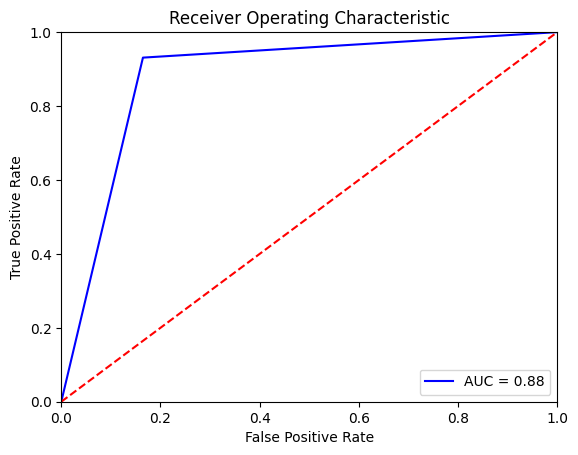

In [74]:
# Plotting ROC
fpr, tpr, threshold = roc_curve(y_val, y_pred)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

##Comparing Model Performance

In [75]:
accuracies = {'Logistic Regression':Lr_accuracy,
              'K-Nearest Neighbor':Knn_accuracy,
              'Decision Tree':Dt_accuracy,
              'Support Vector Machine':SVC_accuracy,
              'Neural Networks':NN_accuracy}

model_accuracy = pd.DataFrame.from_dict(accuracies,orient='index')
model_accuracy.index.name = 'Model'
model_accuracy.rename(columns={model_accuracy.columns[0]:'Accuracy'})

,Accuracy
Model,
Logistic Regression,0.825556
K-Nearest Neighbor,0.929786
Decision Tree,0.906236
Support Vector Machine,0.862625
Neural Networks,0.883123


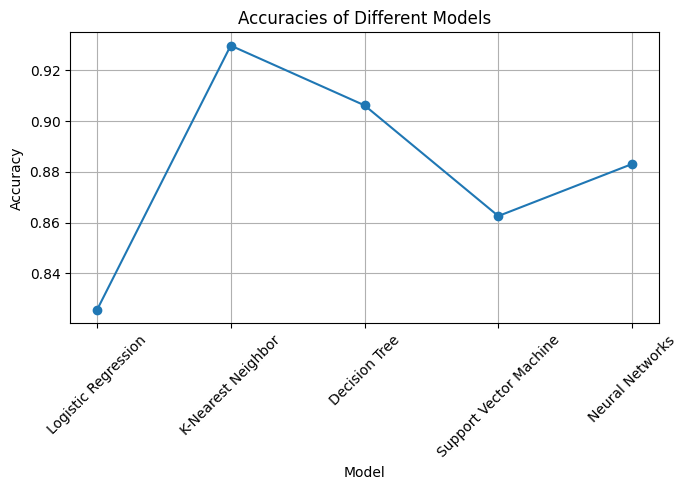

In [76]:
# Plotting the line chart
plt.figure(figsize=(7, 5))
plt.plot(model_accuracy.index, model_accuracy.values, marker='o', linestyle='-')
plt.title('Accuracies of Different Models')
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

##Testing Optimal Model : K-Nearest Neighbors


Model testing on the test data using the model that achieved the highest accuracy during validation.

In [77]:
for k in range(1,6):
    print(f'Testing for {k} neighbour..')
    model = KNeighborsClassifier(n_neighbors=k, metric='manhattan')
    model.fit(X_train,y_train)
    y_pred = model.predict(X_test)

    # Accuracy
    accuracy = accuracy_score(y_test,y_pred)
    print(f'The Accuracy for {k} neighbours is: {round(accuracy,2)}\n')

Testing for 1 neighbour..
The Accuracy for 1 neighbours is: 0.94

Testing for 2 neighbour..
The Accuracy for 2 neighbours is: 0.94

Testing for 3 neighbour..
The Accuracy for 3 neighbours is: 0.92

Testing for 4 neighbour..
The Accuracy for 4 neighbours is: 0.93

Testing for 5 neighbour..
The Accuracy for 5 neighbours is: 0.91



In [78]:
model = KNeighborsClassifier(n_neighbors=2, metric='manhattan')
model.fit(X_train,y_train)

KNeighborsClassifier(metric='manhattan', n_neighbors=2)

In [79]:
y_pred = model.predict(X_test)
Knn_accuracy = accuracy_score(y_test,y_pred)
print(f'The Accuracy of the model using K-Nearest Neighbor is: {round(Knn_accuracy,3)}')

The Accuracy of the model using K-Nearest Neighbor is: 0.939


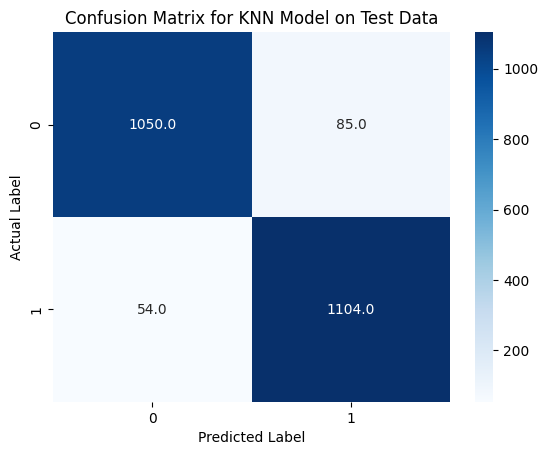

In [80]:
# Plotting the confusion matrix
cm = confusion_matrix(y_test, y_pred)

sns.heatmap(cm, annot=True, fmt='.1f', cmap='Blues')
plt.title('Confusion Matrix for KNN Model on Test Data')
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label');

In [81]:
classification = classification_report(y_test,y_pred)
print(f'The Classification report of the model using K-Nearest Neighbor is:\n {classification}')

The Classification report of the model using K-Nearest Neighbor is:
               precision    recall  f1-score   support

           0       0.95      0.93      0.94      1135
           1       0.93      0.95      0.94      1158

    accuracy                           0.94      2293
   macro avg       0.94      0.94      0.94      2293
weighted avg       0.94      0.94      0.94      2293

